# Rover development notebook (draft/development)

This notebook is for development and testing of the Rover. It is meant to be used with the Rover connected to USB during development.

- The communication with vehicle using [The Simple Communication Protocol for Embedded Applications](https://github.com/nhorro/simpleprotocol).

In [1]:
%load_ext autoreload
%autoreload 2

## Vehicle operation

![img](../../Documentation/Assets/RoverInTestBenchTopView.jpeg)

### Connection to vehicle

Find which port is the vehicle connected to.
In linux, usually it is ttyACM0, ttyACM1, ...

In [2]:
!ls /dev/ttyACM*

/dev/ttyACM0


In [3]:
import sys
sys.path.append("../")
from rover.vehicleif import VehicleIF
vehicle = VehicleIF("/dev/ttyACM0", 115200,debug=False)
vehicle.capture_path = "./captures"

For a quick health check, see current telemetry state:

In [462]:
vehicle.print_telemetry()

General Telemetry
   TelemetryCycle: 45
   OnBoardTime: 27403
   ReceivedPackets: 0
   GeneralStatus: 0x00000008
   Debug1: 0x00000000
   Debug2: 0x00000000
Motor Telemetry
   TelemetryCycle: 44
   OnBoardTime: 26999
   Throttle1: 0.0
   Throttle2: 0.0
   Tachometer1: 0
   Tachometer2: 0
   Tachometer3: 0
   Tachometer4: 0
   MeasuredSpeed1: 0.0
   MeasuredSpeed2: 0.0
   MeasuredSpeed3: 0.0
   MeasuredSpeed4: 0.0
   SetpointSpeed1: 0.0
   SetpointSpeed2: 0.0
   StatusFlags: 0x00000000
IMU Telemetry
   TelemetryCycle: 44
   OnBoardTime: 27201
   Roll: 1.633950960644448e-11
   Pitch: 2.9736979101357974e-08
   Yaw: -4.032090927807985e-08


Exception in thread Thread-5:
Traceback (most recent call last):
  File "/home/nhorro/anaconda3/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    self.run()
  File "/home/nhorro/anaconda3/lib/python3.8/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "../rover/serialif.py", line 35, in _listen
    if self.serial and self.serial.is_open and self.serial.in_waiting:
  File "/home/nhorro/anaconda3/lib/python3.8/site-packages/serial/serialposix.py", line 549, in in_waiting
    s = fcntl.ioctl(self.fd, TIOCINQ, TIOCM_zero_str)
OSError: [Errno 5] Input/output error


For a quick command test, turn on and off led.

In [ ]:
# Led on
vehicle.control_led(0x00000001)

In [ ]:
# Led off
vehicle.control_led(0x00000000)

## Telemetry analysis

The following tests use logged telemetry. Telemetry is received and saved to CSV files. Each telemetry report type is saved to its own file.

The following methods start and stop the logging of all received reports:

- `start_telemetry_csv_logging()`
- `stop_telemetry_csv_logging()`

In [111]:
vehicle.start_telemetry_csv_logging()

In [112]:
vehicle.stop_telemetry_csv_logging()

CSVs will be saved to the `capture_path` variable of the vehicle interface.

In [104]:
!ls {vehicle.capture_path}

tctm.telemetry.GeneralTelemetry.csv  tctm.telemetry.MotorControlTelemetry.csv
tctm.telemetry.IMUTelemetry.csv


In [93]:
import os
import pandas as pd
import matplotlib.pyplot as plt

general_tm_df = pd.read_csv(os.path.join(vehicle.capture_path,"tctm.telemetry.GeneralTelemetry.csv"))
general_tm_df.head(5)

,TelemetryCycle,OnBoardTime,ReceivedPackets,GeneralStatus,Debug1,Debug2
0,97,58599,0,8,0,0
1,98,59187,0,8,0,0
2,99,59796,0,8,0,0
3,100,60384,0,8,0,0
4,101,60993,0,8,0,0


In [92]:
motor_control_tm_df = pd.read_csv(os.path.join(vehicle.capture_path,"tctm.telemetry.MotorControlTelemetry.csv"))
motor_control_tm_df.head(5)

,TelemetryCycle,OnBoardTime,Throttle1,Throttle2,Tachometer1,Tachometer2,Tachometer3,Tachometer4,MeasuredSpeed1,MeasuredSpeed2,MeasuredSpeed3,MeasuredSpeed4,SetpointSpeed1,SetpointSpeed2,StatusFlags
0,97,58788,0.0,0.0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,98,59397,0.0,0.0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,99,59985,0.0,0.0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,100,60594,0.0,0.0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,101,61203,0.0,0.0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [113]:
imu_tm_df = pd.read_csv(os.path.join(vehicle.capture_path,"tctm.telemetry.IMUTelemetry.csv"))
imu_tm_df.head(5)

,TelemetryCycle,OnBoardTime,Roll,Pitch,Yaw
0,12,7989,1.139863e-02,NaN,6.183207e-21
1,13,8598,-7.669461e-32,-8.447101e-18,3.061705e-31
2,14,9186,-4.412346e+32,2.359200e-32,-7.482552e-26
3,15,9795,-2.574852e+05,2.843585e-02,2.607552e-32
4,16,10383,-2.151764e-14,5.446352e-03,-5.454281e-29


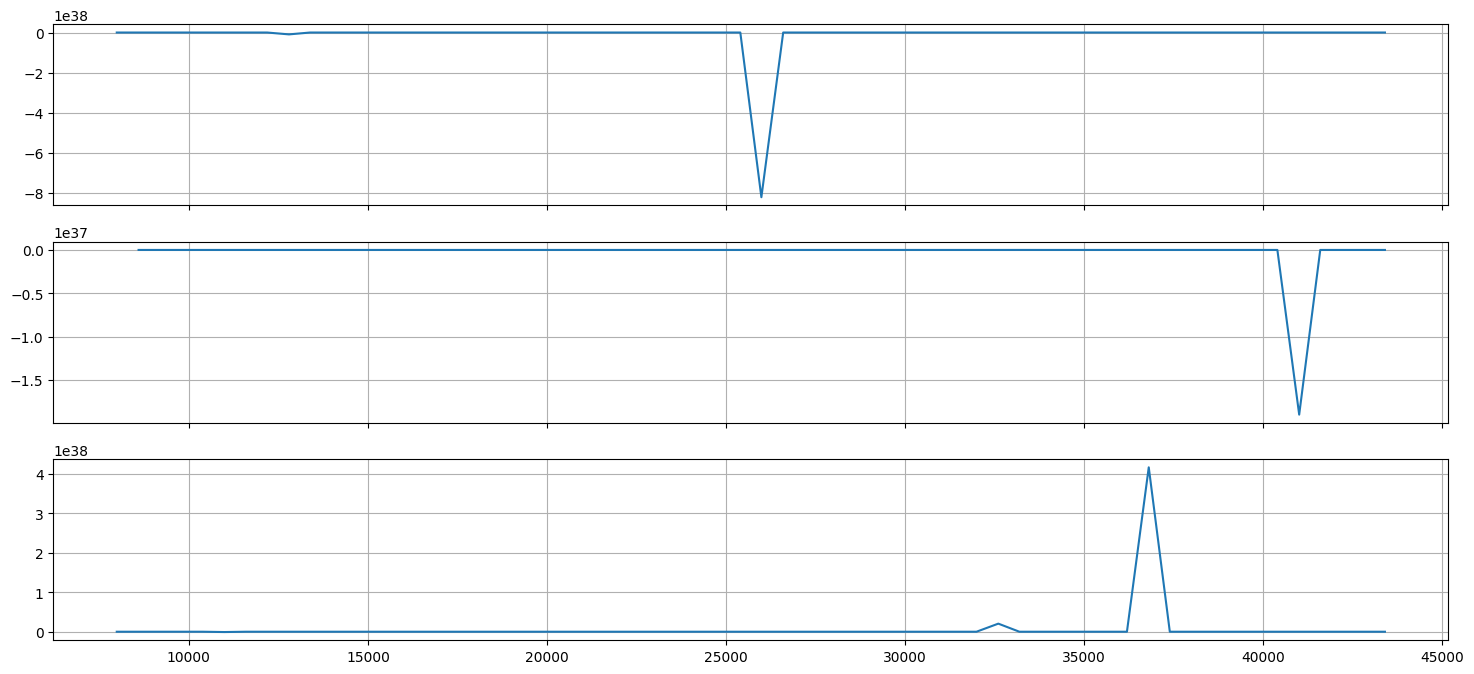

In [114]:
fig,axes = plt.subplots(3,1,figsize=(18,8),sharex=True)
axes[0].plot(imu_tm_df.OnBoardTime,imu_tm_df.Roll*57.2958)
axes[0].grid(which="Both")
axes[1].plot(imu_tm_df.OnBoardTime,imu_tm_df.Pitch*57.2958)
axes[1].grid(which="Both")
axes[2].plot(imu_tm_df.OnBoardTime,imu_tm_df.Yaw*57.2958)
axes[2].grid(which="Both")

## Teardown

In [ ]:
vehicle.shutdown()